In [1]:
#This was a group project, I primarily focused on all of the code here. 
#The dataset shows different variables that contribute to violent and non-violent felonies

In [2]:
from pandas import Series, DataFrame
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree

#import dataset 
#Please make a free account and download the dataset here:
# https://public.enigma.com/datasets/new-york-city-major-felony-incidents/9bff20f8-4476-4f20-9562-5c608872fadc
%pylab inline
df = pd.read_csv('felonydataset.csv')
df.head()

#Observations
df.columns

Populating the interactive namespace from numpy and matplotlib


Index(['objectid', 'identifier', 'occurrence_date', 'day_of_week',
       'occurrence_month', 'occurrence_day', 'occurrence_year',
       'occurrence_hour', 'compstat_month', 'compstat_day', 'compstat_year',
       'offense', 'offense_classification', 'sector', 'precinct', 'borough',
       'jurisdiction', 'xcoordinate', 'ycoordinate', 'location_1_zip',
       'location_1_city', 'location_1_state', 'location_1_address',
       'serialid'],
      dtype='object')

In [3]:
#What is object id? Is this the id of the felony?
df['objectid'].value_counts()

#Since there are some ids that occur more than 1 time in the dataset and there is no description, we decided to drop them.
#Furthermore, we decided to drop features that we believe will not predict a felony, for example, the year that a felony occuried.
#We also dropped features that had blank columns

df = df.drop(['occurrence_date','occurrence_day','occurrence_year','objectid', 'identifier','location_1_zip', 'location_1_city', 'location_1_state', 'location_1_address','offense_classification','compstat_month', 'compstat_day','compstat_year', 'serialid', 'xcoordinate', 'ycoordinate'], axis = 1)
df.head()


,day_of_week,occurrence_month,occurrence_hour,offense,sector,precinct,borough,jurisdiction
0,Saturday,Nov,2.0,GRAND LARCENY,H,84.0,BROOKLYN,N.Y. POLICE DEPT
1,Monday,Jul,12.0,GRAND LARCENY,G,1.0,MANHATTAN,N.Y. POLICE DEPT
2,Friday,Oct,11.0,GRAND LARCENY,D,9.0,MANHATTAN,N.Y. POLICE DEPT
3,Tuesday,Oct,9.0,GRAND LARCENY,C,24.0,MANHATTAN,N.Y. POLICE DEPT
4,Friday,Oct,11.0,BURGLARY,K,45.0,BRONX,N.Y. POLICE DEPT


In [4]:
#Data Cleaning
df.head(10)

#Check if there are any unusual values 
df['jurisdiction'].value_counts()


#The dataset manually has "(null)" - we want to change these to null values 
mask = (df['jurisdiction']) == "(null)"
df.loc[mask,'jurisdiction'] = np.nan
df['jurisdiction'].value_counts()

#Day of week is clean
df['day_of_week'].value_counts()
#Occurrence_month is clean
df['occurrence_month'].value_counts()

#Occurence_hour is clean - we will later feature engineer this into 4 hour counts
df['occurrence_hour'].value_counts()

#Offense is clean
df['offense'].value_counts()

#Sector is clean-The dataset doesn't really tell us what sector is.
#https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts/66th-precinct.page
#From this link, we can assume that precincts have different sectors
df['sector'].value_counts()

#Precinct Check - is clean
df['precinct'].value_counts()

#Borough is NOT CLEAN - has (null)
df['borough'].value_counts()
mask = (df['borough']) == "(null)"
df.loc[mask,'borough'] = np.nan
df['borough'].value_counts()




BROOKLYN         351517
MANHATTAN        287812
QUEENS           243802
BRONX            207578
STATEN ISLAND     32668
Name: borough, dtype: int64

In [5]:
#Drop nulls

#Check length of df before dropping null
print("Length before",len(df))

#Drop any row that has a null value 
df = df.dropna(how='any',axis=0) 

#Check length of df after dropping null
print("Length after dropping null", len(df))



Length before 1123465
Length after dropping null 1097805


In [6]:
#Feature Engineering Hours
#We thought we could see trends in 4 hour chunks rather than each hour 
bins = [0, 4, 8, 12, 16, 20, 24]

df['binned_hours'] = pd.cut(df['occurrence_hour'], bins = bins)
df['binned_hours'].value_counts()

(16, 20]    233971
(12, 16]    225500
(8, 12]     192429
(20, 24]    152451
(0, 4]      131476
(4, 8]      106372
Name: binned_hours, dtype: int64

In [7]:
df.columns

Index(['day_of_week', 'occurrence_month', 'occurrence_hour', 'offense',
       'sector', 'precinct', 'borough', 'jurisdiction', 'binned_hours'],
      dtype='object')

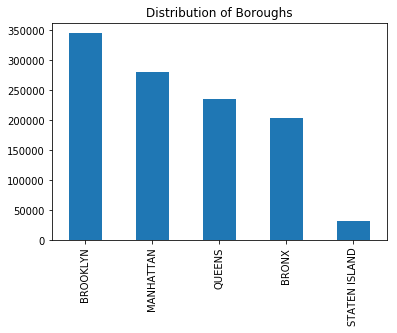

In [8]:
#Univariate analysis
borough_counts = df['borough'].value_counts()
borough_counts.plot(kind = 'bar')

plt.title("Distribution of Boroughs")

#Most common borough that has felonies is Brooklyn
plt.savefig('Distribution of Boroughs.png')


Text(0.5,1,'Top 10 Precincts with Most Felonies')

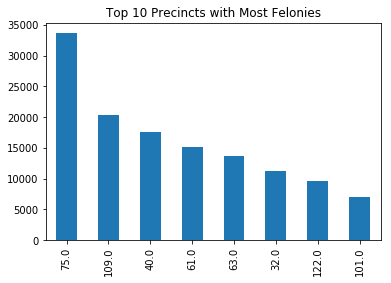

In [9]:
precinct_counts = df['precinct'].value_counts()[::10].plot(kind='bar')
plt.title("Top 10 Precincts with Most Felonies")

Text(0.5,1,'Count of felonies with respect to the day of the week')

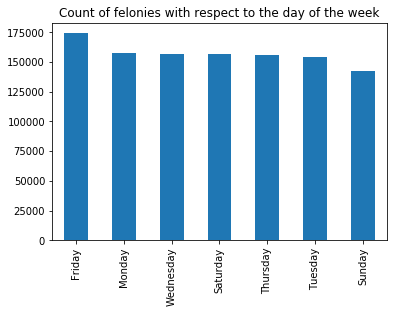

In [10]:
day_counts = df['day_of_week'].value_counts()
day_counts.plot(kind = 'bar')

plt.title('Count of felonies with respect to the day of the week')

Text(0.5,1,'Count of felonies with respect to month')

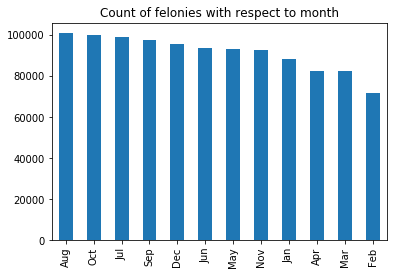

In [11]:
month_counts = df['occurrence_month'].value_counts()
month_counts.plot(kind = 'bar')

plt.title('Count of felonies with respect to month')

Text(0.5,1,'Count of felonies with respect to four-hour intervals throughout the day')

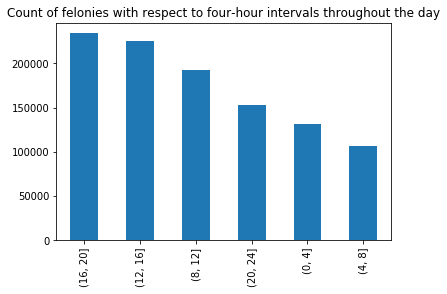

In [12]:
hour_counts = df['binned_hours'].value_counts()
hour_counts.plot(kind = 'bar')

# each x-axis label corresponds to each a four-hour interval


plt.title('Count of felonies with respect to four-hour intervals throughout the day')

Text(0.5,1,'Count of each felony')

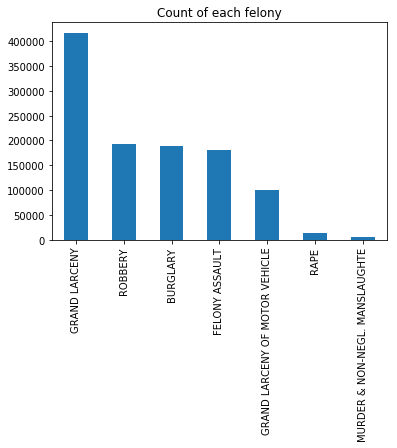

In [13]:
offense_counts = df['offense'].value_counts()
offense_counts
offense_counts.plot(kind = 'bar')

plt.title('Count of each felony')

Text(0.5,1,'Distribution of dataset with respect to offense')

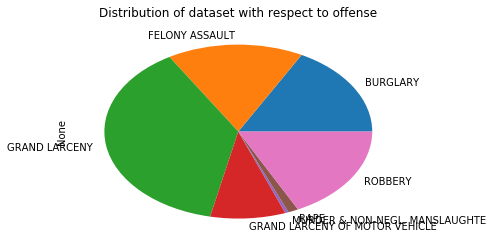

In [14]:
groups= df.groupby('offense')

groups.size().plot.pie()
# The slices will be ordered and plotted counter-clockwise.

plt.title("Distribution of dataset with respect to offense")

In [15]:
#Bivariate Analysis
#We wanted to see if there were any trends between the offense and day of the week
counts = df.groupby(['offense','day_of_week'])[['day_of_week']].count()
print('Count of each felony with respect to the day of the week')
counts

Count of each felony with respect to the day of the week


day_of_week
offense                        day_of_week             
BURGLARY                       Friday             34046
                               Monday             28288
                               Saturday           22518
                               Sunday             18327
                               Thursday           28497
                               Tuesday            27562
                               Wednesday          29164
FELONY ASSAULT                 Friday             24753
                               Monday             23399
                               Saturday           31348
                               Sunday             32622
                               Thursday           22672
                               Tuesday            22993
                               Wednesday          22578
GRAND LARCENY                  Friday             68063
                               Monday             60433
                               Saturday           58210
                               Sunday             49075
                               Thursday           61065
                               Tuesday            59818
                               Wednesday          60861
GRAND LARCENY OF MOTOR VEHICLE Friday             15526
                               Monday             14411
                               Saturday           14450
                               Sunday             13542
                               Thursday           14109
                               Tuesday            13813
                               Wednesday          13984
MURDER & NON-NEGL. MANSLAUGHTE Friday               631
                               Monday               591
                               Saturday             811
                               Sunday               829
                               Thursday             539
                               Tuesday              538
                               Wednesday            536
RAPE                           Friday              2026
                               Monday              1796
                               Saturday            2264
                               Sunday              2191
                               Thursday            1741
                               Tuesday             1734
                               Wednesday           1733
ROBBERY                        Friday             29102
                               Monday             28641
                               Saturday           26866
                               Sunday             25967
                               Thursday           27297
                               Tuesday            28069
                               Wednesday          27776

In [16]:
#We wanted to see if there were any trends between the offense and month 
counts = df.groupby(['occurrence_month','offense'])[['offense']].count()
print('Count of each felony with respect to month')
counts

Count of each felony with respect to month


offense
occurrence_month offense                                
Apr              BURGLARY                          13550
                 FELONY ASSAULT                    14460
                 GRAND LARCENY                     31875
                 GRAND LARCENY OF MOTOR VEHICLE     7667
                 MURDER & NON-NEGL. MANSLAUGHTE      329
...                                                  ...
Sep              GRAND LARCENY                     36821
                 GRAND LARCENY OF MOTOR VEHICLE     9299
                 MURDER & NON-NEGL. MANSLAUGHTE      402
                 RAPE                               1143
                 ROBBERY                           17443

[84 rows x 1 columns]

In [17]:
#We wanted to see if there were any trends between the offense and month 
counts = df.groupby(['borough','offense'])[['offense']].count()
print('Count of each felony with respect to month')
counts

Count of each felony with respect to month


offense
borough       offense                                
BRONX         BURGLARY                          33262
              FELONY ASSAULT                    47091
              GRAND LARCENY                     53479
              GRAND LARCENY OF MOTOR VEHICLE    21742
              MURDER & NON-NEGL. MANSLAUGHTE     1168
              RAPE                               2968
              ROBBERY                           44440
BROOKLYN      BURGLARY                          65295
              FELONY ASSAULT                    61467
              GRAND LARCENY                    112382
              GRAND LARCENY OF MOTOR VEHICLE    32678
              MURDER & NON-NEGL. MANSLAUGHTE     1788
              RAPE                               4025
              ROBBERY                           68048
MANHATTAN     BURGLARY                          34551
              FELONY ASSAULT                    32165
              GRAND LARCENY                    163160
              GRAND LARCENY OF MOTOR VEHICLE    10286
              MURDER & NON-NEGL. MANSLAUGHTE      609
              RAPE                               2869
              ROBBERY                           37374
QUEENS        BURGLARY                          48572
              FELONY ASSAULT                    34321
              GRAND LARCENY                     77482
              GRAND LARCENY OF MOTOR VEHICLE    31669
              MURDER & NON-NEGL. MANSLAUGHTE      764
              RAPE                               3100
              ROBBERY                           39556
STATEN ISLAND BURGLARY                           6722
              FELONY ASSAULT                     5321
              GRAND LARCENY                     11022
              GRAND LARCENY OF MOTOR VEHICLE     3460
              MURDER & NON-NEGL. MANSLAUGHTE      146
              RAPE                                523
              ROBBERY                            4300

In [18]:
#Feature Engineering
#To accurately represent the structure of the data and create the best model. 
def converttoclasslabels(s):
      if s in["GRAND LARCENY", 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE']:
        s = "Non-Violent Crimes"
        return s
      else:   
        return "Violent Crimes"

df['label'] = df['offense'].map(converttoclasslabels)
df['label'].value_counts()

Non-Violent Crimes    705762
Violent Crimes        392043
Name: label, dtype: int64

In [19]:
# We need to do one hot encoding because we have categorical variables.
df['day_of_week'] = pd.Categorical(df['day_of_week'])
df['occurrence_month'] = pd.Categorical(df['occurrence_month'])
df['binned_hours'] = pd.Categorical(df['binned_hours'])
df['sector'] = pd.Categorical(df['sector'])
df['precinct'] = pd.Categorical(df['precinct'])
df['borough'] = pd.Categorical(df['borough'])
df['jurisdiction'] = pd.Categorical(df['jurisdiction'])


In [20]:
dfDummies = pd.get_dummies(df['day_of_week'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)

dfDummies = pd.get_dummies(df['occurrence_month'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)

dfDummies = pd.get_dummies(df['binned_hours'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)

dfDummies = pd.get_dummies(df['sector'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)

dfDummies = pd.get_dummies(df['precinct'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)

dfDummies = pd.get_dummies(df['borough'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)

dfDummies = pd.get_dummies(df['jurisdiction'], prefix = 'category')
df = pd.concat([df, dfDummies], axis=1)




In [21]:
df = df.drop(['day_of_week','occurrence_month','binned_hours','occurrence_hour','offense', 'sector', 'precinct','borough','jurisdiction'], axis = 1)
df.columns

Index(['label', 'category_Friday', 'category_Monday', 'category_Saturday',
       'category_Sunday', 'category_Thursday', 'category_Tuesday',
       'category_Wednesday', 'category_Apr', 'category_Aug',
       ...
       'category_NEW YORK CITY SHERIFF OFFICE',
       'category_NYC DEPT ENVIRONMENTAL PROTECTION',
       'category_NYS DEPT TAX && FINANCE', 'category_OTHER',
       'category_POLICE DEPT NYC', 'category_PORT AUTHORITY',
       'category_SEA GATE POLICE DEPT', 'category_STATN IS RAPID TRANS',
       'category_TRI-BORO BRDG TUNNL', 'category_U.S. PARK POLICE'],
      dtype='object', length=160)

In [27]:
#Decision Trees

#splitting labels and feature values
data_Y = df['label']
data_X = df.drop(['label'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=None)

print("Training is", len(X_train))
print("Test is ",len(X_test))

data_X.columns

Training is 735529
Test is  362276


Index(['category_Friday', 'category_Monday', 'category_Saturday',
       'category_Sunday', 'category_Thursday', 'category_Tuesday',
       'category_Wednesday', 'category_Apr', 'category_Aug', 'category_Dec',
       ...
       'category_NEW YORK CITY SHERIFF OFFICE',
       'category_NYC DEPT ENVIRONMENTAL PROTECTION',
       'category_NYS DEPT TAX && FINANCE', 'category_OTHER',
       'category_POLICE DEPT NYC', 'category_PORT AUTHORITY',
       'category_SEA GATE POLICE DEPT', 'category_STATN IS RAPID TRANS',
       'category_TRI-BORO BRDG TUNNL', 'category_U.S. PARK POLICE'],
      dtype='object', length=159)

In [28]:
#We don't need PCA in decision trees.
# Create a decision tree
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train, y_train)



In [29]:
pred_Y = clf.predict(X_test)
from sklearn.metrics import accuracy_score

print('Accuracy on test data is:', (accuracy_score(y_test, pred_Y)*100))

Accuracy on test data is: 64.82102043745653


In [30]:
#I assisted my other group members running various predictive models with cross validation.

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Scores: [0.65214698 0.64817548 0.64360864 0.64946256 0.64954454 0.64933503
 0.64559118 0.64878849 0.64895245 0.64744034]
Accuracy: 64.83045689073114
